# Bayesian Linear Regression
Based on the Seoul Bike Sharing Demand dataset located at ../data/SeoulBikeData.csv
Load the data and split into train and test sets, 80% for training and 20% for testing.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pymc as pm
import arviz as az

Data Preprocessing, make sure to convert the categorical variables into numeric variables.

In [36]:
file_path = '../data/SeoulBikeData.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
numeric_season = {'Spring' : 1, 'Summer' : 2, 'Autumn' : 3, 'Winter' : 4}
numeric_holiday = {'No Holiday' : 0, 'Holiday' : 1}
numeric_functioning_day = {'No' : 0, 'Yes' : 1}
df['Seasons'] = df['Seasons'].map(numeric_season)
df['Holiday'] = df['Holiday'].map(numeric_holiday)
df['Functioning Day'] = df['Functioning Day'].map(numeric_functioning_day)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Month'] = df['Date'].dt.month
# df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

print(df.shape)
print(df.head())
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']

(8760, 14)
   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  Da

In [37]:
# process the data normalization
X_np = X.to_numpy(dtype=np.float32)
y_np = y.to_numpy(dtype=np.float32)
print(X_np.shape)
print(y_np.shape)
print("X_train dtype:", X_np.dtype)
print("y_train dtype:", y_np.dtype)

scaler = StandardScaler()
columns_to_scale = X.columns.difference(['Seasons', 'Holiday', 'Functioning Day', 'DayOfWeek'])
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
print(X.head())

(8760, 13)
(8760,)
X_train dtype: float32
y_train dtype: float32
       Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0 -1.661325        -1.513957    -1.042483          0.458476          0.925871   
1 -1.516862        -1.539074    -0.993370         -0.892561          0.925871   
2 -1.372399        -1.580936    -0.944257         -0.699556          0.925871   
3 -1.227936        -1.597680    -0.895144         -0.796059          0.925871   
4 -1.083473        -1.580936    -1.091596          0.554978          0.925871   

   Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  \
0                  -1.659605                -0.655132       -0.1318   
1                  -1.659605                -0.655132       -0.1318   
2                  -1.667262                -0.655132       -0.1318   
3                  -1.659605                -0.655132       -0.1318   
4                  -1.736177                -0.655132       -0.1318   

   Snowfall (cm)  Sea

In [38]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (7008, 13)
Test set size: (1752, 13)


#### Bayesian Linear Regression
Use PyMC to perform Bayesian Linear Regression on your new dataset. 

In [39]:
# define the model
num_samples = 1000
model = pm.Model()

with model:
    
    n_features = X_train.shape[1]
    beta = pm.Normal('beta', mu=0, sigma=10, shape=n_features)

    
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    
    sigma = pm.HalfCauchy('sigma', beta=10)

    
    mu = alpha + pm.math.dot(X_train, beta)

    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    
    trace = pm.sample(num_samples, return_inferencedata=True)

summary = az.summary(trace)
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


             mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    29.272   0.844   27.657   30.851      0.013    0.009    4410.0   
beta[1]    38.440   1.729   35.183   41.729      0.036    0.026    2284.0   
beta[2]    -2.830   0.303   -3.412   -2.263      0.006    0.004    2795.0   
beta[3]     0.377   5.110   -9.556    9.502      0.086    0.079    3484.0   
beta[4]     0.067   0.011    0.046    0.087      0.000    0.000    3410.0   
beta[5]   -10.520   1.711  -13.830   -7.317      0.036    0.026    2243.0   
beta[6]   -42.405   6.671  -55.780  -30.592      0.106    0.075    3980.0   
beta[7]   -50.447   5.016  -59.613  -40.822      0.072    0.052    4905.0   
beta[8]     5.833   7.982   -9.441   20.401      0.115    0.115    4891.0   
beta[9]   -21.913   5.072  -31.604  -12.906      0.080    0.057    3991.0   
beta[10]  -21.290   9.242  -38.621   -3.874      0.129    0.096    5155.0   
beta[11]   84.345   9.761   65.760  102.330      0.149    0.107    4306.0   

Posterior Predictive Check, plot the posterior predictive distribution of the model

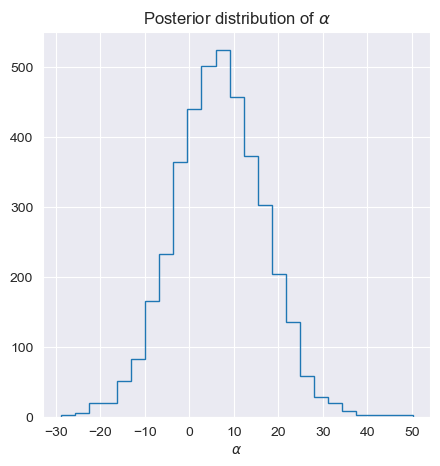

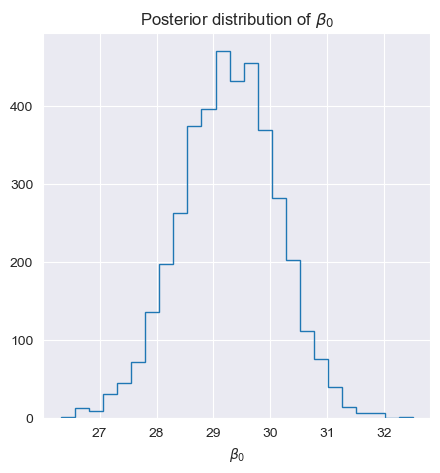

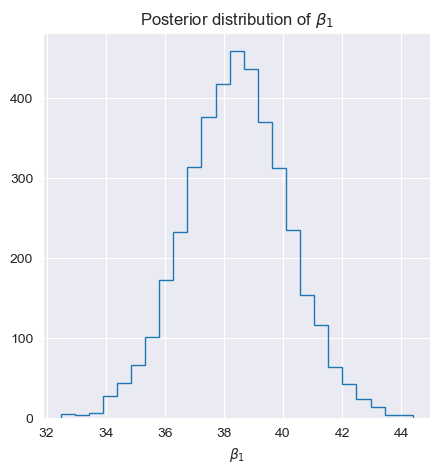

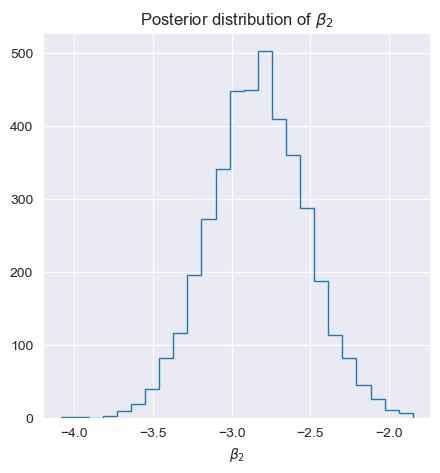

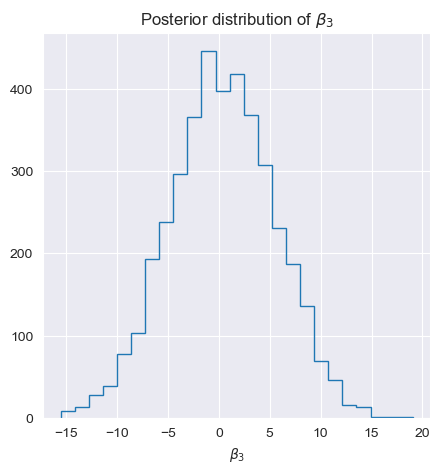

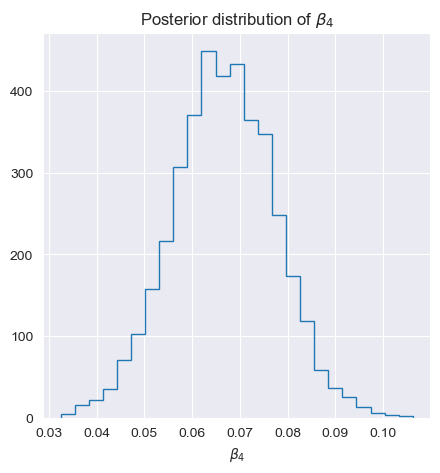

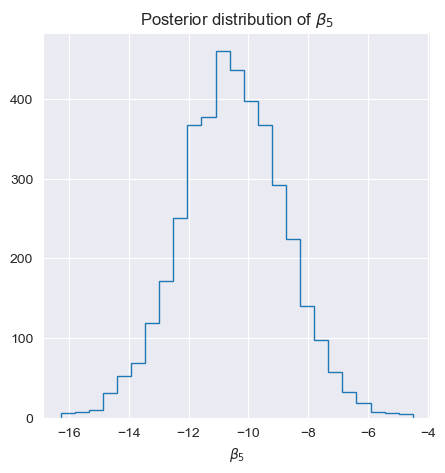

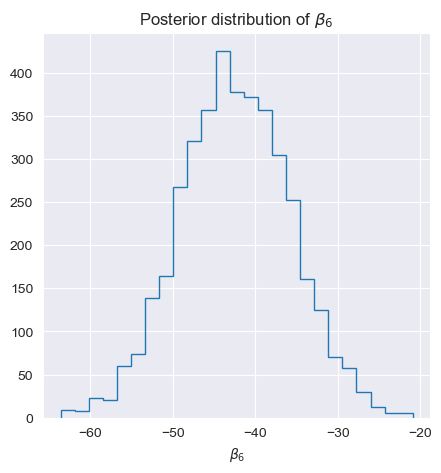

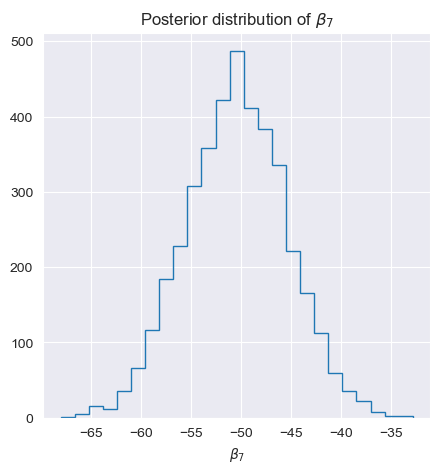

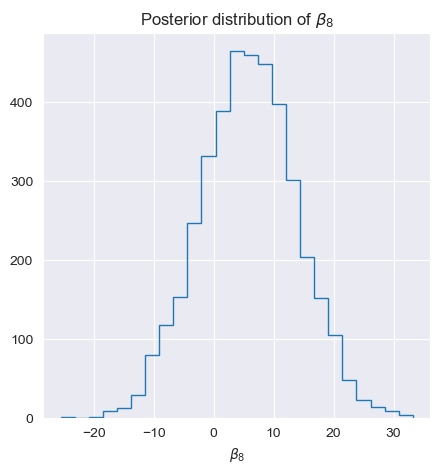

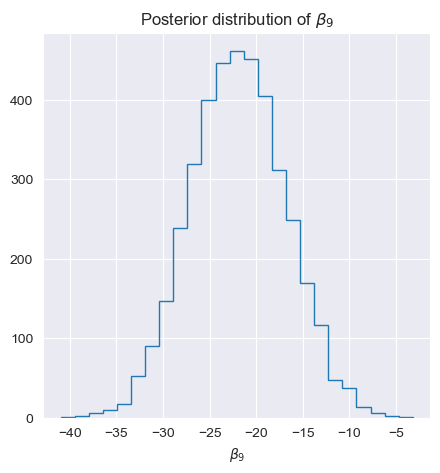

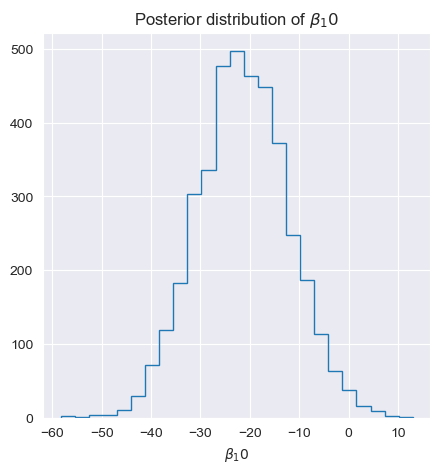

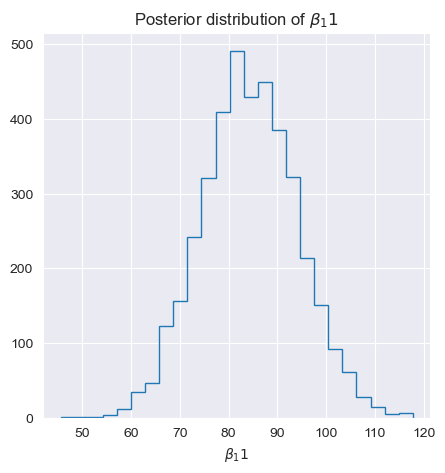

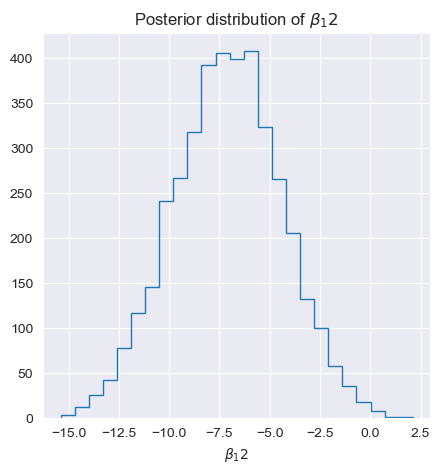

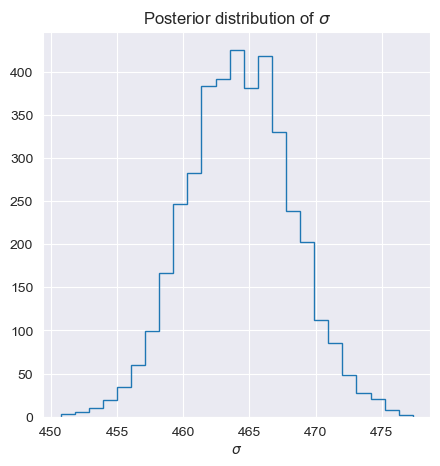

In [40]:
# plot the posterior distributions
plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['alpha'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\alpha$')
plt.title('Posterior distribution of $\\alpha$')
plt.show()

# for 13 betas in the model 
for i in range(trace.posterior['beta'].shape[-1]):
    plt.figure(figsize=(5, 5))
    plt.hist(trace.posterior['beta'].sel(beta_dim_0=i).values.flatten(), bins=25, histtype='step')
    plt.xlabel(f'$\\beta_{i}$')
    plt.title(f'Posterior distribution of $\\beta_{i}$')
    plt.show()


plt.figure(figsize=(5, 5))
plt.hist(trace.posterior['sigma'].values.flatten(), bins=25, histtype='step')
plt.xlabel('$\\sigma$')
plt.title('Posterior distribution of $\\sigma$')
plt.show()


<Figure size 1000x1000 with 0 Axes>

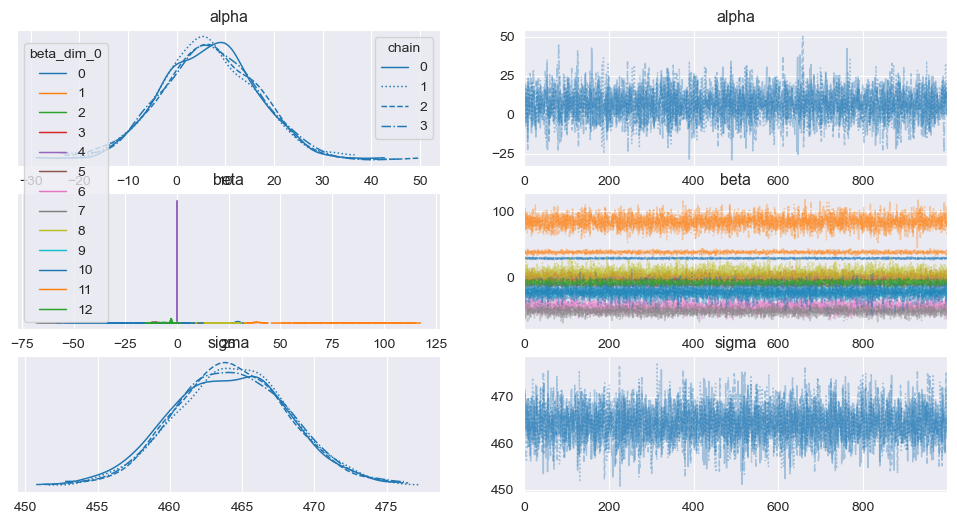

In [41]:
plt.figure(figsize=(10, 10))
az.plot_trace(trace, combined=False, var_names=['alpha', 'beta', 'sigma'], legend=True)
plt.show()

Summery posterior mean value for each model parameter generated by arviz.summary

In [42]:
# print the summary of the posterior distribution
summary = az.summary(trace)
print(summary)

             mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    29.272   0.844   27.657   30.851      0.013    0.009    4410.0   
beta[1]    38.440   1.729   35.183   41.729      0.036    0.026    2284.0   
beta[2]    -2.830   0.303   -3.412   -2.263      0.006    0.004    2795.0   
beta[3]     0.377   5.110   -9.556    9.502      0.086    0.079    3484.0   
beta[4]     0.067   0.011    0.046    0.087      0.000    0.000    3410.0   
beta[5]   -10.520   1.711  -13.830   -7.317      0.036    0.026    2243.0   
beta[6]   -42.405   6.671  -55.780  -30.592      0.106    0.075    3980.0   
beta[7]   -50.447   5.016  -59.613  -40.822      0.072    0.052    4905.0   
beta[8]     5.833   7.982   -9.441   20.401      0.115    0.115    4891.0   
beta[9]   -21.913   5.072  -31.604  -12.906      0.080    0.057    3991.0   
beta[10]  -21.290   9.242  -38.621   -3.874      0.129    0.096    5155.0   
beta[11]   84.345   9.761   65.760  102.330      0.149    0.107    4306.0   